### Import, Load, and Prep Data

**Import** Libraries, Palettes, and Helper Funcs

In [26]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px

# Palettes
import sys

sys.path.append(r'C:\Users\svtee\DAI')

from helper.my_funcs import (classic_color, 
                             yacht_club_color, 
                             bold_basics_color,
                             basic_brights_color,
                             beeswax_clay_color,
                             main_color
                             )

# Functions
sys.path.append(r'C:\Users\svtee\DAI\case_studies\python-eda-case-study\notebooks')

from shane.clean_transform_func import clean_transform_extract

# Font dictionaries
title_font = {'family':'arial',
              'weight':'bold',
              'size':20,
              'color':'black'
              }

tick_font = {'family':'arial',
             'weight':'normal',
             'size':12,
             'color':'black'
             }

axis_label_font = {'family':'arial',
                   'weight':'bold',
                   'size':14,
                   'color':'black'
                   }

**Clean & Transform**

In [ ]:
def clean_transform_extract(csv_file_path, json_file_path, cleaned_csv_file_path):
    '''
    Purpose:
    - Clean: Address errors, duplicates, or NaN/Empty values, if applicable
    - Transform: Convert columns to workable dtype or workable format
    - Extract: Pull relevant data from json df and return it to csv df

    Paramenters:
    - yt_df: the `USvideos.csv` that will serve as the primary df during case study
    - yt_json_df: the `US_category_id.json` that serves as the mechanism for extracting
    category id, name key, value pairs and returning to `yt_df`

    Actions:
    - See comments below 

    Outputs:
    - Cleaned and transformed `yt_df`
    - An array of all unique tags in the `yt_df['tags']` column
    - A dictionary of all `category_id`, `category_name` key, value pairs
    '''
    import pandas as pd
    yt_df = pd.read_csv(csv_file_path)
    yt_json_df = pd.read_json(json_file_path)

    # Converts datetime columns to datetime dtypes based on specific formats
    # Converts `publish_time to UTC datetime format`
    yt_df['publish_time'] = pd.to_datetime(
        arg=yt_df['publish_time'], 
        errors='coerce',
        )
    # Converts `trending_date` to datetime format (`yy-dd-mm`-based)
    yt_df['trending_date'] = pd.to_datetime(
        arg=yt_df['trending_date'], 
        errors='coerce', 
        format='%y.%d.%m',
        )
    
    # Category names
    # Creates a dictionary of category id (keys) and names (values)
    cat_id_name_dict = dict(
        zip(
            yt_json_df['items'].str.get('id').astype(int),
            yt_json_df['items'].str.get('snippet').str.get('title')
            )
        )    
    # Inserts category names into a new column using the dictionary
    # and `category_id` column as a map
    yt_df.insert(
        loc=5, 
        column='category_name', 
        value=yt_df['category_id'].map(cat_id_name_dict)
        )

    # Inserts three new columns based on the `publish_time` column
    # Inserts month column
    yt_df.insert(
        loc=yt_df.columns.get_loc('publish_time') + 1, 
        column='publish_time_month', 
        value=yt_df['publish_time'].dt.month_name()
        )
    # Inserts day of week name column
    yt_df.insert(
        loc=yt_df.columns.get_loc('publish_time') + 2, 
        column='publish_time_day_name', 
        value=yt_df['publish_time'].dt.day_name()
        )
    # Inserts date column
    yt_df.insert(
        loc=yt_df.columns.get_loc('publish_time') + 3, 
        column='publish_time_date', 
        value=yt_df['publish_time'].dt.date
        )

    # Inserts two new columns based on the `trending_date` column
    # Inserts month column
    yt_df.insert(
        loc=yt_df.columns.get_loc('trending_date') + 1, 
        column='trending_date_month', 
        value=yt_df['trending_date'].dt.month_name()
        )
    # Inserts day of week name column
    yt_df.insert(
        loc=yt_df.columns.get_loc('trending_date') + 2, 
        column='trending_date_day_name', 
        value=yt_df['trending_date'].dt.day_name()
        )
    
    range_series = (
    yt_df.groupby('video_id')['trending_date'].max()
      - yt_df.groupby('video_id')['trending_date'].min()
        ).dt.days
    yt_df.insert(
        loc=yt_df.columns.get_loc('trending_date') + 3, 
        column='num_days_trending', 
        value=yt_df['video_id'].map(range_series)
    )

    # Replaces the values in the `tags` column
    # with a list of individual tags as opposed to a single string
    yt_df['tags'] = yt_df['tags'].str.split('|')
    tag_arr = yt_df['tags'].explode().str.strip('"').str.lower().value_counts(ascending=False).drop('[none]')

    yt_df.to_csv(cleaned_csv_file_path, index=False)
      
    # Returns the tag_dict the dictionary
    return yt_df, tag_arr

In [27]:
yt_df, tag_arr = clean_transform_extract('../../.gitignore/data/USvideos.csv', '../../.gitignore/data/US_category_id.json', '../../.gitignore/data/cleaned_yt_df.csv')

In a separate cell block, execute the following line of code: clean_yt_df = pd.read_csv('../../.gitignore/data/cleaned_yt_df.csv')


**View** Cleaned Data

In [28]:
# Verify dtype of columns
yt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                40949 non-null  object             
 1   trending_date           40949 non-null  datetime64[ns]     
 2   trending_date_month     40949 non-null  object             
 3   trending_date_day_name  40949 non-null  object             
 4   num_days_trending       40949 non-null  int64              
 5   title                   40949 non-null  object             
 6   channel_title           40949 non-null  object             
 7   category_id             40949 non-null  int64              
 8   category_name           40949 non-null  object             
 9   publish_time            40949 non-null  datetime64[ns, UTC]
 10  publish_time_month      40949 non-null  object             
 11  publish_time_day_name   40949 non-null  o

In [29]:
# Verify df transformed correctly
yt_df.head()

,video_id,trending_date,trending_date_month,trending_date_day_name,num_days_trending,title,channel_title,category_id,category_name,publish_time,...,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,2017-11-14,November,Tuesday,6,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,People & Blogs,2017-11-13 17:13:01+00:00,...,[SHANtell martin],748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,2017-11-14,November,Tuesday,6,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,Entertainment,2017-11-13 07:30:00+00:00,...,"[last week tonight trump presidency, ""last wee...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,2017-11-14,November,Tuesday,6,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,Comedy,2017-11-12 19:05:24+00:00,...,"[racist superman, ""rudy"", ""mancuso"", ""king"", ""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,2017-11-14,November,Tuesday,6,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,Entertainment,2017-11-13 11:00:04+00:00,...,"[rhett and link, ""gmm"", ""good mythical morning...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,2017-11-14,November,Tuesday,5,I Dare You: GOING BALD!?,nigahiga,24,Entertainment,2017-11-12 18:01:41+00:00,...,"[ryan, ""higa"", ""higatv"", ""nigahiga"", ""i dare y...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [30]:
# Remove duplicate values based on `video_id`
# This ensures that we do not count videos more than once
dupe_counts = yt_df["video_id"].value_counts()
print(dupe_counts)


duplicate_rows = yt_df[yt_df["video_id"].isin(dupe_counts.index)]
print(duplicate_rows.sort_values("video_id"))

unique_videos = yt_df.drop_duplicates(subset='video_id')
unique_videos.head()

video_id
j4KvrAUjn6c    30
8h--kFui1JA    29
QBL8IRJ5yHU    29
t4pRQ0jn23Q    29
MAjY8mCTXWk    29
               ..
QDHcA33yT0I     1
6XxA-4Jp7AU     1
GIRJck1pVRA     1
Wpr2WvQn-kg     1
yz7Xq3T0YPs     1
Name: count, Length: 6351, dtype: int64
          video_id trending_date trending_date_month trending_date_day_name  \
39584  -0CMnp02rNY    2018-06-08                June                 Friday   
40208  -0CMnp02rNY    2018-06-11                June                 Monday   
40007  -0CMnp02rNY    2018-06-10                June                 Sunday   
39795  -0CMnp02rNY    2018-06-09                June               Saturday   
39375  -0CMnp02rNY    2018-06-07                June               Thursday   
...            ...           ...                 ...                    ...   
32774  zxwfDlhJIpw    2018-05-05                 May               Saturday   
33637  zxwfDlhJIpw    2018-05-09                 May              Wednesday   
144    zy0b9e40tK8    2017-11-14          

,video_id,trending_date,trending_date_month,trending_date_day_name,num_days_trending,title,channel_title,category_id,category_name,publish_time,...,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,2017-11-14,November,Tuesday,6,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,People & Blogs,2017-11-13 17:13:01+00:00,...,[SHANtell martin],748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,2017-11-14,November,Tuesday,6,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,Entertainment,2017-11-13 07:30:00+00:00,...,"[last week tonight trump presidency, ""last wee...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,2017-11-14,November,Tuesday,6,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,Comedy,2017-11-12 19:05:24+00:00,...,"[racist superman, ""rudy"", ""mancuso"", ""king"", ""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,2017-11-14,November,Tuesday,6,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,Entertainment,2017-11-13 11:00:04+00:00,...,"[rhett and link, ""gmm"", ""good mythical morning...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,2017-11-14,November,Tuesday,5,I Dare You: GOING BALD!?,nigahiga,24,Entertainment,2017-11-12 18:01:41+00:00,...,"[ryan, ""higa"", ""higatv"", ""nigahiga"", ""i dare y...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


### Most Common Day to Publish

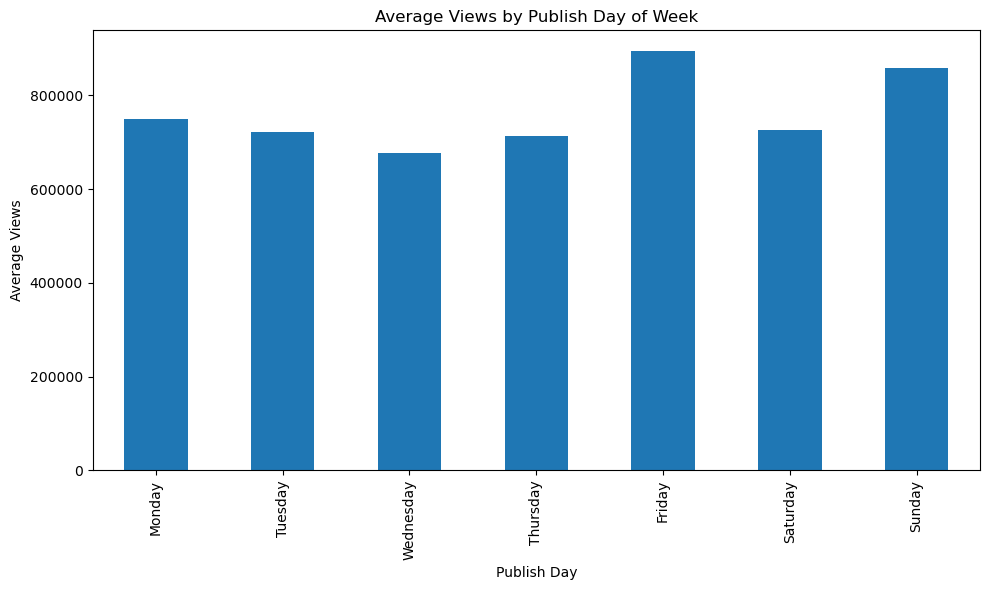

In [31]:
unique_videos = yt_df.drop_duplicates(subset='video_id')
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pop_by_day = (
    unique_videos
      .groupby('publish_time_day_name')['views']
      .mean()
      .reindex(day_order)
)

fig, ax = plt.subplots(figsize=(10,6))
pop_by_day.plot(kind='bar', ax=ax)
ax.set_title('Average Views by Publish Day of Week')
ax.set_xlabel('Publish Day')
ax.set_ylabel('Average Views')
plt.tight_layout()
plt.show()

### Days with Most View

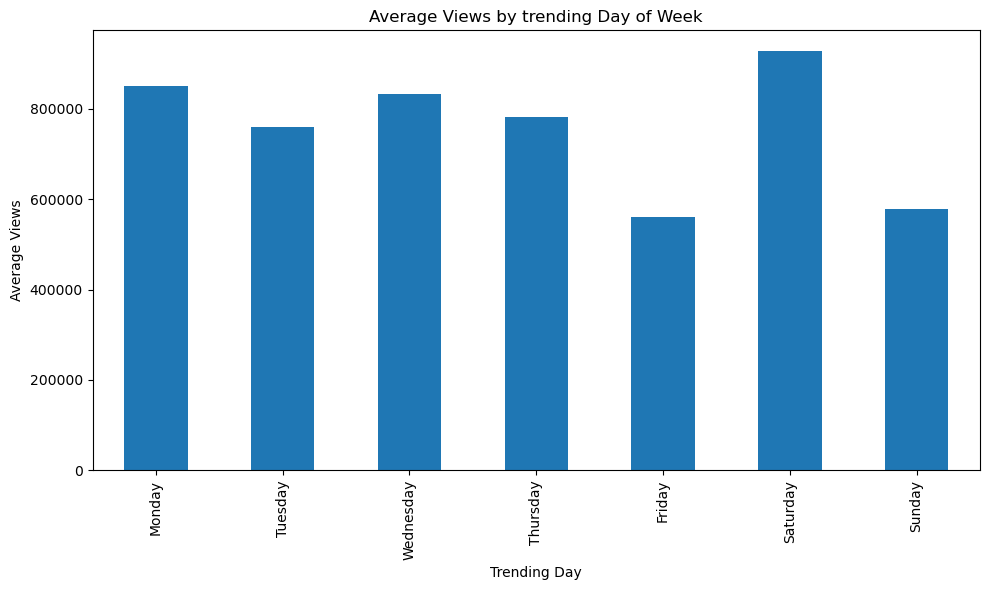

In [32]:
unique_videos = yt_df.drop_duplicates(subset='video_id')
day_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pop_by_day = (
    unique_videos
      .groupby('trending_date_day_name')['views']
      .mean()
      .reindex(day_order)
)
fig, ax = plt.subplots(figsize=(10,6))
pop_by_day.plot(kind='bar', ax=ax)
ax.set_title('Average Views by trending Day of Week')
ax.set_xlabel('Trending Day')
ax.set_ylabel('Average Views')
plt.tight_layout()
plt.show()

### Count of Videos Per Category

C:\Users\svtee\AppData\Local\Temp\ipykernel_61196\4120041563.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


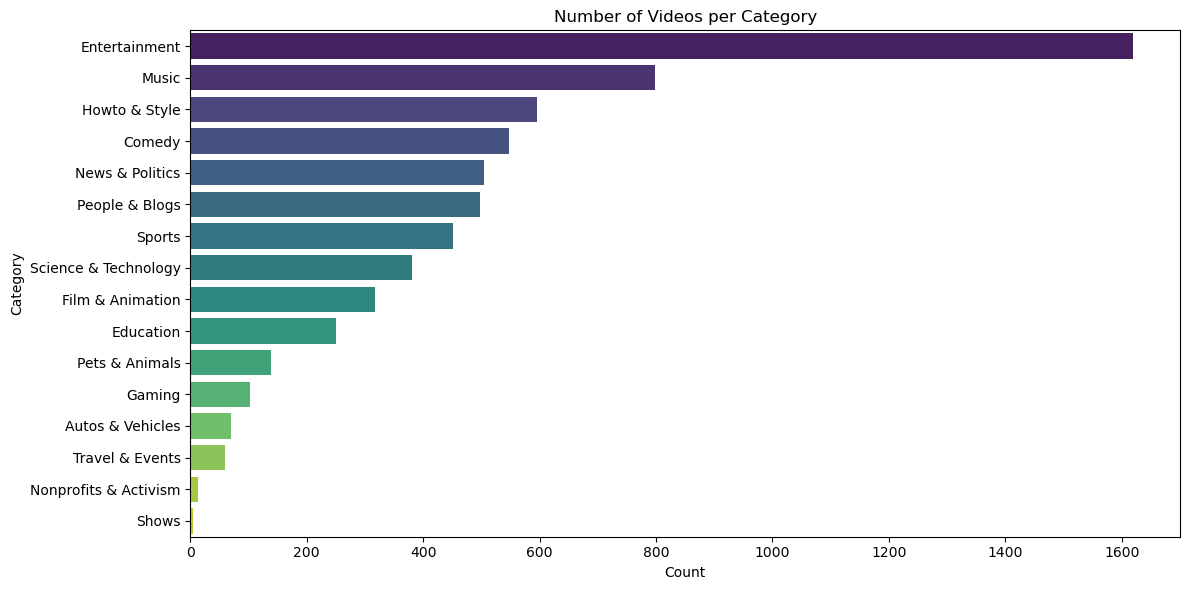

In [33]:
counts = unique_videos["category_name"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(
    y=counts.index,
    x=counts.values,
    palette=sns.color_palette("viridis", len(counts)),
    orient="h",
)
plt.title("Number of Videos per Category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show();

### Average Views per Category

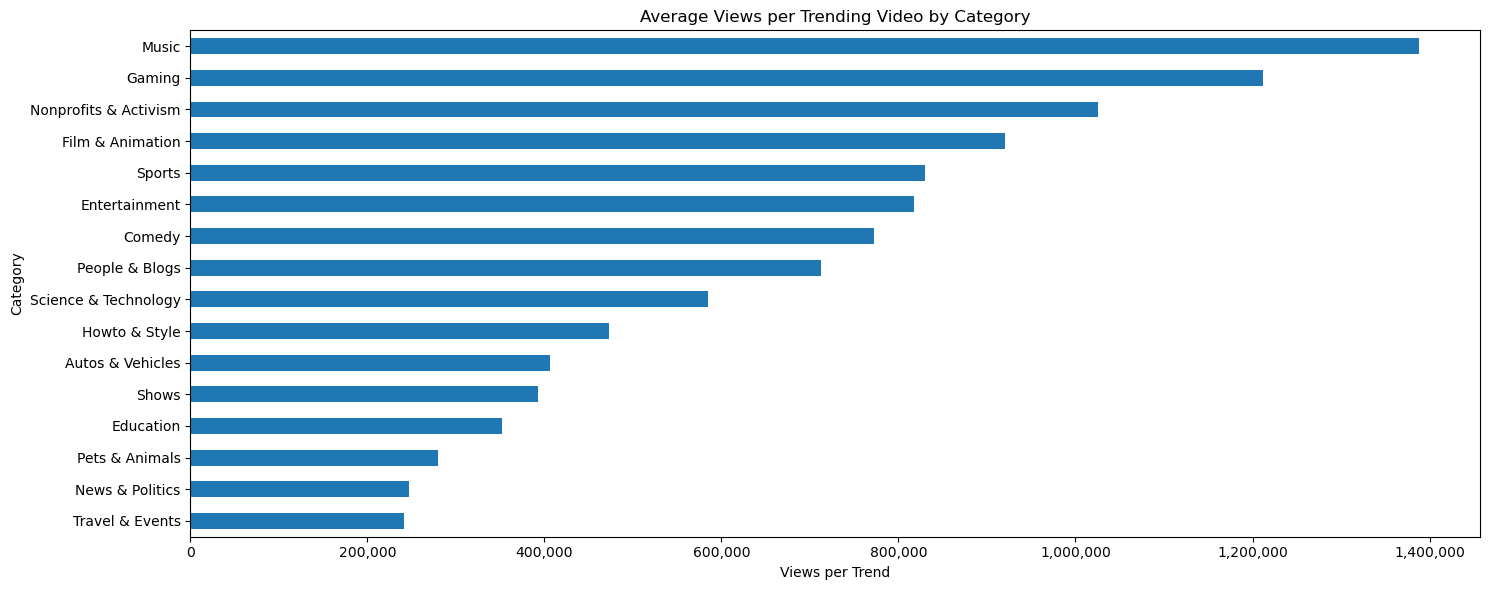

In [39]:
# Create new dataframe
summary = unique_videos.groupby("category_name").agg(
    total_views = ("views", "sum"),
    count       = ("views", "size")
)

# Assigning values to new columns in new dataframe
summary["views_per_trend"] = summary["total_views"] / summary["count"]
power_summary = summary.sort_values("views_per_trend", ascending=True)

# Plot of new data frame
fig, ax = plt.subplots(figsize=(15,6))
power_summary["views_per_trend"].plot.barh(ax=ax)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_title("Average Views per Trending Video by Category")
ax.set_xlabel("Views per Trend")
ax.set_ylabel("Category")
plt.tight_layout()
plt.show()

### Average Number of Days Trending

C:\Users\svtee\AppData\Local\Temp\ipykernel_61196\1278159357.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


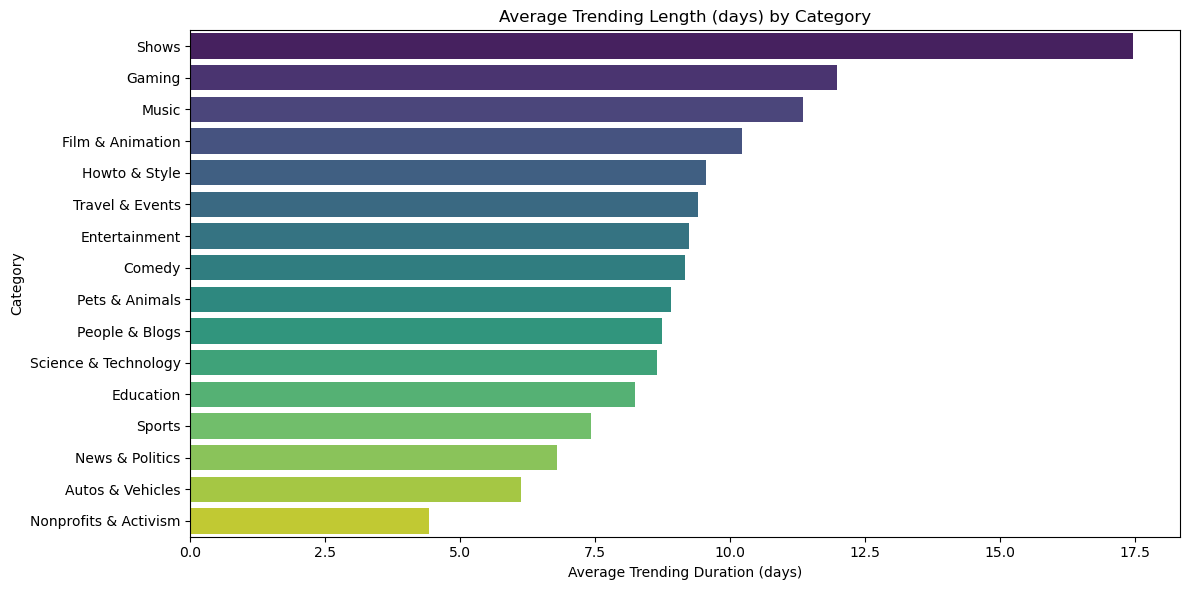

In [ ]:
avg_trend_days = (
    yt_df.groupby('category_name')['num_days_trending']
         .mean()
         .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(
    x=avg_trend_days.values,
    y=avg_trend_days.index,
    palette='viridis',
    orient='h'
)
plt.xlabel('Average Trending Duration (days)')
plt.ylabel('Category')
plt.title('Average Trending Length (days) by Category')
plt.tight_layout()
plt.show()

### Overview of Most Common Tags

In [ ]:
tags_over_1_000 = tag_arr[tag_arr.values >= 1000]
tags_over_1_000

tags
funny         4142
comedy        3647
how to        1702
music         1664
pop           1634
trailer       1413
food          1280
2018          1275
news          1254
review        1239
makeup        1238
science       1237
humor         1210
celebrity     1130
diy           1110
tutorial      1054
video         1031
television    1024
live          1020
Name: count, dtype: int64

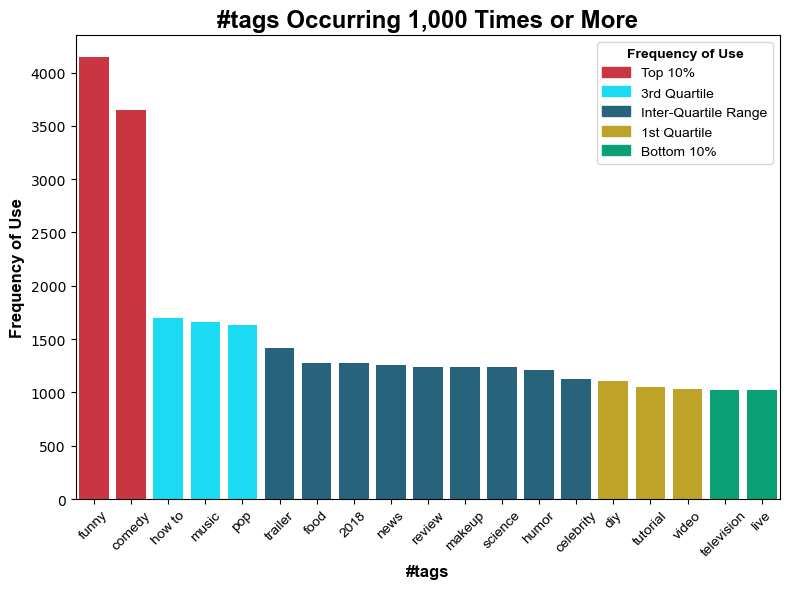

In [52]:
tags_over_1_000 = tag_arr[tag_arr.values >= 1000]
tags_over_1_000

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(tags_over_1_000.index, tags_over_1_000.values, label=tags_over_1_000.index)
for bar in bars:
    if bar.get_height() >= np.percentile(tags_over_1_000, 90):
        bar.set_facecolor(main_color[0])
    if bar.get_height() >= np.percentile(tags_over_1_000, 75) and bar.get_height() < np.percentile(tags_over_1_000, 90):
        bar.set_facecolor(main_color[1])
    if bar.get_height() < np.percentile(tags_over_1_000, 75) and bar.get_height() > np.percentile(tags_over_1_000, 25):
        bar.set_facecolor(main_color[2])
    if bar.get_height() <= np.percentile(tags_over_1_000, 25) and bar.get_height() > np.percentile(tags_over_1_000, 10):
        bar.set_facecolor(main_color[3])
    if bar.get_height() <= np.percentile(tags_over_1_000, 10):
        bar.set_facecolor(main_color[4])

title_font = {'family': 'arial',
        'style': 'normal',
        'variant': 'normal',
        'stretch': 'normal',
        'weight': 'bold',
        'size': 'xx-large',
        'color': 'black'        
        }
tick_font = {'family': 'arial',
        'style': 'normal',
        'variant': 'normal',
        'stretch': 'normal',
        'weight': 'normal',
        'size': 'medium',
        'color': 'black'        
        }
axis_label_font = {'family': 'arial',
        'style': 'normal',
        'variant': 'normal',
        'stretch': 'normal',
        'weight': 'bold',
        'size': 'large',
        'color': 'black'        
        }

ax.set_title('#tags Occurring 1,000 Times or More', fontdict=title_font)
ax.set_xticks(ticks=tags_over_1_000.index)
ax.set_xticklabels(labels=tags_over_1_000.index, fontdict=tick_font, rotation=45)
ax.set_xmargin(m=0.005)
ax.set_xlabel('#tags', fontdict=axis_label_font)
ax.set_ylabel('Frequency of Use', fontdict=axis_label_font)

handles = [
    mpatches.Patch(color=main_color[0], label='Top 10%'),
    mpatches.Patch(color=main_color[1], label='3rd Quartile'),
    mpatches.Patch(color=main_color[2], label='Inter-Quartile Range'),
    mpatches.Patch(color=main_color[3], label='1st Quartile'),
    mpatches.Patch(color=main_color[4], label='Bottom 10%')
]

legend_title_font = {'family': 'arial',
        'style': 'normal',
        'variant': 'normal',
        'stretch': 'normal',
        'weight': 'bold',
        'size': 'medium',
        }

legend_text_font = {'family': 'arial',
        'style': 'normal',
        'variant': 'normal',
        'stretch': 'normal',
        'weight': 'normal',
        'size': 'medium',
        }

ax.legend(handles=handles, 
          title='Frequency of Use',
          title_fontproperties=legend_title_font,
          prop=legend_text_font,
          loc='upper right')
fig.tight_layout();